# Case study: the Ames housing dataset

Foundations of Data Science

## The Ames housing problem

![](https://datasciencebocconi.github.io/Images/ames_housing/housesbanner.png)

-   Suppose you are interested in <span style="color:DarkOrange">buying
    a new house</span> in the town of Ames, which is located in the US
    state of Iowa.

-   You want to focus your search on houses that you expect to be able
    to afford.

-   Can you <span style="color:DarkOrange">predict</span> the price of
    the house based on its characteristics?

-   This is a
    [**Kaggle**](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
    playground competition. You can join the competition if you like.
    Keep in mind that the entire dataset, including the test set, is
    public…

    De Cock, D. 2011. “Ames, Iowa: Alternative to the Boston Housing
    Data as an End of Semester Regression Project.” Journal of
    Statistics Education 19 (3).

## Problem description

-   This is a prediction problem in which the **sale price** is the
    <span style="color:DarkOrange">output</span> variable (response).

-   You have some information from all of the houses sold over the past
    few years, including the number of bedrooms, the size of the house,
    the year the house was built, etc.

-   This unit is organized into two sections:

    1.  We clean the data and perform some
        <span style="color:DarkOrange">exploratory data analysis</span>
        to gain some preliminary understanding of the data;
    2.  We exploit advanced regression techniques to predict the price
        of the house using all the remaining
        <span style="color:DarkOrange">input</span> variables
        (covariates).

-   In other words, we will try to estimate a function $f(\cdot)$ such
    that $$
    (\texttt{SalePrice}) = f(\texttt{GarageArea},\texttt{Neighborhood}, \dots) + \epsilon.
    $$

## A first look at the data

In [1]:
import pandas as pd
ames = pd.read_csv("https://datasciencebocconi.github.io/Data/AmesHousing.csv")
ames.head(10)

10 rows × 82 columns

-   The `ames` dataset has $2930$ observations (rows), each representing
    a different <span style="color:DarkOrange">building</span> in Ames,
    Iowa.

-   There are $82$ variables (columns), including our target:
    `SalePrice`.

## Read the documentation

-   The first thing we need to do is understand the
    <span style="color:DarkOrange">meaning of each variable</span>.

In [2]:
ames.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

-   We have access to a detailed
    [documentation](https://datasciencebocconi.github.io/Data/ames_documentation.txt).
    Reading the documentation can be time-consuming… but it is the most
    important part of the analysis.

## Houses or commercial activities?

-   A minority of the observations are
    <span style="color:DarkOrange">non residential</span> buildings, as
    indicated by the `MS Zoning` variable.

In [3]:
ames['MS Zoning'].value_counts()

MS Zoning
RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: count, dtype: int64

-   Our goal is to predict the price of a **residential** building,
    therefore, it makes sense to
    <span style="color:DarkOrange">exclude</span> these observations
    from the dataset.

In [4]:
ames = ames[ames['MS Zoning'] != "C (all)"] # Commercial sales
ames = ames[ames['MS Zoning'] != "I (all)"] # Industrial sales
ames = ames[ames['MS Zoning'] != "A (agr)"] # Agricultural sales
ames = ames[ames['MS Zoning'] != "FV"] # Floating village sales

## Sales typology

-   There is a second caveat. In the original ames dataset, there are
    different <span style="color:DarkOrange">type of sales</span>:

In [5]:
ames['Sale Condition'].value_counts()

Sale Condition
Normal     2305
Partial     203
Abnorml     174
Family       46
Alloca       22
AdjLand      12
Name: count, dtype: int64

-   The prices of non-standard sales might be skewed. Moreover, we do
    not want to predict the price based on the type of sales
    (`Sale Type`).

-   We are interested only in `Normal` sales, therefore we
    <span style="color:DarkOrange">exclude</span> adjoining land
    purchases, deed re-allocations, internal-family sales, and
    incomplete houses.

In [6]:
ames = ames[ames['Sale Condition'] == "Normal"] # Only normal sales
ames = ames.drop(columns = ['Sale Condition', 'Sale Type']) # These variables can be dropped

-   We are left with $n = 2305$ observations and $80$ variables after
    these operations.

In [7]:
ames.shape

(2305, 80)

## Variables and documentation

-   From the documentation, we learn that both `Order` and `PID` can be
    removed from the dataset, as they carry no information about
    `SalePrice`.

In [8]:
ames = ames.drop(columns = ['Order', 'PID'])

-   Moreover, we can build some intuition and expectations about the
    variables. A few randomly selected examples:
    -   The variable `Overall Qual` looks important, being the *rate of
        the overall material and finish of the house*;
    -   Do we need both `GarageCars` and `GarageArea` as predictors?
    -   A few variables have <span style="color:DarkOrange">structural
        missing data</span>, such as `FireplaceQu`, i.e. the quality of
        the fireplace.
-   <span style="color:DarkOrange">General tip</span>: ask yourself as
    many questions as possible about the data: what is the correct
    typology of each variable? Is it numerical, ordinal, or discrete?
    are there *irrelevant* variables?)

## The output variable

-   <span style="color:DarkOrange">General tip</span>: start any data
    analysis by <span style="color:DarkOrange">making graphs</span> and
    calculating some <span style="color:DarkOrange">descriptive
    statistics</span> of the key variables.

In [9]:
import matplotlib.pyplot as plt # Main graphical library
import seaborn as sns # More advanced graphs

-   The most important variable is `SalesPrice`, being our target:

In [10]:
ames['SalePrice'].describe()

count      2305.000000
mean     174639.636876
std       71091.154811
min       35000.000000
25%      129000.000000
50%      157000.000000
75%      203000.000000
max      755000.000000
Name: SalePrice, dtype: float64

-   Thus, the average cost of a house in Ames is about 175k USD, ranging
    from a minimum of 35k to a maximum of 755k.

## The output variable II

-   The distribution of `SalePrice` is slightly asymmetric, as is often
    the case with prices. <span style="color:DarkOrange">Idea</span>:
    what about taking the log?

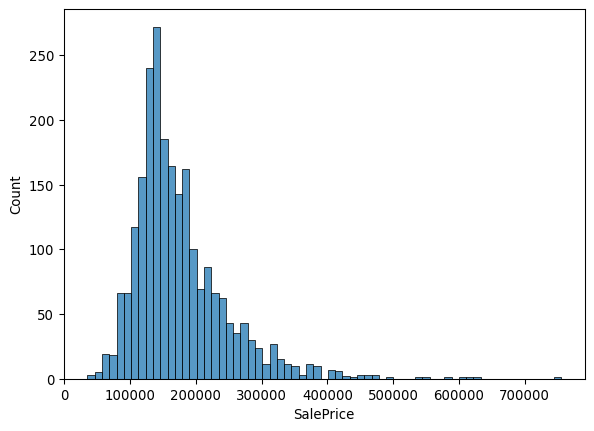

In [11]:
plt.close()
sns.histplot(ames['SalePrice'])
plt.show()

## Recoding of `MS SubClass`

In [12]:
ames['MS SubClass'].value_counts()

MS SubClass
20     850
60     435
50     243
120    144
30     112
70     108
80     106
160     80
90      78
190     48
85      42
75      21
45      17
180     14
40       6
150      1
Name: count, dtype: int64

In [13]:
# Mapping of old values to new values (Taken from the documentation)
ms_subclass_mapping = {
    "20": "One_Story_1946_and_Newer_All_Styles",
    "30": "One_Story_1945_and_Older",
    "40": "One_Story_with_Finished_Attic_All_Ages",
    "45": "One_and_Half_Story_Unfinished_All_Ages",
    "50": "One_and_Half_Story_Finished_All_Ages",
    "60": "Two_Story_1946_and_Newer",
    "70": "Two_Story_1945_and_Older",
    "75": "Two_and_Half_Story_All_Ages",
    "80": "Split_or_Multilevel",
    "85": "Split_Foyer",
    "90": "Duplex_All_Styles_and_Ages",
    "120": "One_Story_PUD_1946_and_Newer",
    "150": "One_and_Half_Story_PUD_All_Ages",
    "160": "Two_Story_PUD_1946_and_Newer",
    "180": "PUD_Multilevel_Split_Level_Foyer",
    "190": "Two_Family_conversion_All_Styles_and_Ages"
}

# Apply mapping to the column
ames['MS SubClass'] = ames['MS SubClass'].astype(str).map(ms_subclass_mapping)
ames['MS SubClass'].value_counts()

MS SubClass
One_Story_1946_and_Newer_All_Styles          850
Two_Story_1946_and_Newer                     435
One_and_Half_Story_Finished_All_Ages         243
One_Story_PUD_1946_and_Newer                 144
One_Story_1945_and_Older                     112
Two_Story_1945_and_Older                     108
Split_or_Multilevel                          106
Two_Story_PUD_1946_and_Newer                  80
Duplex_All_Styles_and_Ages                    78
Two_Family_conversion_All_Styles_and_Ages     48
Split_Foyer                                   42
Two_and_Half_Story_All_Ages                   21
One_and_Half_Story_Unfinished_All_Ages        17
PUD_Multilevel_Split_Level_Foyer              14
One_Story_with_Finished_Attic_All_Ages         6
One_and_Half_Story_PUD_All_Ages                1
Name: count, dtype: int64

## Missing values

-   The `ames` dataset has a lot of
    <span style="color:DarkOrange">missing values</span>, most of which
    are **structural**.

In [14]:
freq = ames.isnull().sum().sort_values(ascending=False)
rel_freq = freq / ames.shape[0]
tab = pd.concat([freq, rel_freq], axis=1, keys=['Frequency', 'Rel. frequency'])
tab.head(25) # Showing just a few of them

-   Imputation is not a good idea for most of these variables. A missing
    value for `Pool QC` means that there is no pool in the house,
    therefore, we should not try to “impute” it.

-   Instead, it makes much more sense to
    <span style="color:DarkOrange">recode</span> these categorical
    variables.

## Handling missing values I

## `Alley`

In [15]:
ames['Alley'].value_counts(dropna = False)

Alley
NaN     2187
Grvl      99
Pave      19
Name: count, dtype: int64

-   Missing values have been re-coded.

In [16]:
ames['Alley'] = ames['Alley'].fillna('No alley access')
ames['Alley'].value_counts(dropna = False)

Alley
No alley access    2187
Grvl                 99
Pave                 19
Name: count, dtype: int64

## `Bsmt *`

-   Missing values have been re-coded.

In [17]:
ames['Bsmt Exposure'] = ames['Bsmt Exposure'].fillna('No basement')
ames['Bsmt Cond'] = ames['Bsmt Cond'].fillna('No basement')
ames['Bsmt Exposure'] = ames['Bsmt Exposure'].fillna('No basement')
ames['BsmtFin Type 1'] = ames['BsmtFin Type 1'].fillna('No basement')
ames['BsmtFin Type 2'] = ames['BsmtFin Type 2'].fillna('No basement')
ames['Bsmt Qual'] = ames['Bsmt Qual'].fillna('No basement')

-   There are two missing values in `Bsmt Full Bath` and
    `Bsmt Half Bath`, which we impute with the most common value.

In [18]:
ames['Bsmt Full Bath'].value_counts(dropna = False)

Bsmt Full Bath
0.0    1329
1.0     952
2.0      23
NaN       1
Name: count, dtype: int64

In [19]:
ames['Bsmt Full Bath'] = ames['Bsmt Full Bath'].fillna(0)
ames['Bsmt Half Bath'] = ames['Bsmt Half Bath'].fillna(0)

## `Electrical`

-   The missing values have been imputed with the most common
    observation.

In [20]:
ames['Electrical'].value_counts(dropna = False)

Electrical
SBrkr    2105
FuseA     155
FuseF      39
FuseP       5
NaN         1
Name: count, dtype: int64

In [21]:
ames['Electrical'] = ames['Electrical'].fillna('SBrkr')

## `Fence`

-   Missing values have been re-coded.

In [22]:
ames['Fence'].value_counts(dropna = False)

Fence
NaN      1806
MnPrv     285
GdPrv     106
GdWo       98
MnWw       10
Name: count, dtype: int64

In [23]:
ames['Fence'] = ames['Fence'].fillna('No fence')

## `Fireplace Qu`

-   Missing values have been re-coded.

In [24]:
ames['Fireplace Qu'].value_counts(dropna = False)

Fireplace Qu
NaN    1103
TA      535
Gd      530
Fa       67
Po       43
Ex       27
Name: count, dtype: int64

In [25]:
ames['Fireplace Qu'] = ames['Fireplace Qu'].fillna('No fireplace')

## `Garage *`

-   We re-coded all the variables for the garage.

In [26]:
ames['Garage Cond'] = ames['Garage Cond'].fillna('No garage')
ames['Garage Finish'] = ames['Garage Finish'].fillna('No garage')
ames['Garage Qual'] = ames['Garage Qual'].fillna('No garage')
ames['Garage Type'] = ames['Garage Type'].fillna('No garage')

-   The variable `Garage Yr Blt` is more problematic. By replacing
    missing values with `No garage` would transform this variable into a
    categorical variable.

-   For the sake of simplicity, given its low predictive value (i.e.,
    the year of construction of the garage); in this analysis, we just
    exclude this variable.

In [27]:
ames = ames.drop(columns = ['Garage Yr Blt']) # The variable can be dropped

## Handling missing values II

## `Lot Frontage`

-   From the documentation: *Lot Frontage (Continuous): Linear feet of
    street connected to property*.

-   Even though it is not specified in the documentation, it is
    reasonable replace missing values with $0$ (no street).

In [28]:
ames['Lot Frontage'] = ames['Lot Frontage'].fillna(0)

## `Mas Vnr *`

In [29]:
ames['Mas Vnr Type'].value_counts(dropna = False)

Mas Vnr Type
NaN        1421
BrkFace     721
Stone       145
BrkCmn       18
Name: count, dtype: int64

In [30]:
ames['Mas Vnr Area'].value_counts(dropna = False)

Mas Vnr Area
0.0      1405
120.0      11
108.0      10
NaN         9
340.0       9
         ... 
187.0       1
387.0       1
45.0        1
22.0        1
443.0       1
Name: count, Length: 384, dtype: int64

-   It is not clear what missing values represent: (i) an actual missing
    or (ii) the absence of the feature.

-   In both cases (i) and (ii) it makes sense to perform the following:

In [31]:
ames['Mas Vnr Type'] = ames['Mas Vnr Type'].fillna('None')
ames['Mas Vnr Area'] = ames['Mas Vnr Area'].fillna(0)

## `Misc Feature`

-   Missing values are re-coded. Tennis (\`TenC\` is aggregated with the
    other categories:

In [32]:
ames['Misc Feature'].value_counts(dropna = False)

Misc Feature
NaN     2210
Shed      86
Gar2       5
Othr       3
TenC       1
Name: count, dtype: int64

In [33]:
ames['Misc Feature'] = ames['Misc Feature'].fillna('No additional feature')
ames['Misc Feature'] = ames['Misc Feature'].replace(['TenC'],'Othr')

## `Pool QC`

In [34]:
ames['Pool QC'].value_counts(dropna = False)

Pool QC
NaN    2296
TA        3
Ex        2
Gd        2
Fa        2
Name: count, dtype: int64

-   Missing values have been re-coded. All the other values have been
    aggregated.

In [35]:
ames['Pool QC'] = ames['Pool QC'].fillna('No')
ames['Pool QC'] = ames['Pool QC'].replace(['TA','Ex','Gd', 'Fa'],'Yes')

## Feature engineering

-   By “feature engineering,” we mean the process of creating
    <span style="color:DarkOrange">new interesting variables</span>,
    possibly having a a direct relationship with the response.

-   The first example is the total dimension of the Porch, obtained as
    the sum of all its sub-components.

In [36]:
ames['Porch Sq Feet'] = ames['Open Porch SF'] + ames['Enclosed Porch'] + ames['3Ssn Porch'] + ames['Screen Porch']

-   In a similar spirit, we can create a variable counting the total
    number of bathrooms in the house.

In [37]:
ames['Tot Bathrooms'] = ames['Full Bath'] + 0.5 * ames['Half Bath'] + ames['Bsmt Full Bath'] + 0.5 * ames['Bsmt Half Bath'] 

-   Finally, we create the variable indicating the “Age” of the house.

In [38]:
ames['House Age'] = ames['Yr Sold'] - ames['Year Remod/Add']

## Deleting irrelevant variables

-   The theory suggests that <span style="color:DarkOrange">more
    variables</span> = <span style="color:DarkOrange">higher
    variance</span> of the estimates.

-   Thus, deleting irrelevant variables is a valuable practice as long
    as we expect them to be **not** related to the target variables and
    because we believe the information is already contained in other
    variables.

-   We already deleted `Order` and `PID` before, but other examples are
    the following variables:

In [39]:
# The information is already included in House Age
ames = ames.drop(columns = ['Mo Sold', 'Yr Sold', 'Year Remod/Add', 'Year Built']) 
# The information is already included in Porch Sq Feet
ames = ames.drop(columns = ['Open Porch SF', 'Enclosed Porch', '3Ssn Porch','Screen Porch']) 
# The information is already included in Tot Bathrooms
ames = ames.drop(columns = ['Full Bath', 'Half Bath', 'Bsmt Full Bath','Bsmt Half Bath']) 
# Very little information is present in these variables
ames = ames.drop(columns = ['Pool Area', 'Utilities']) 

## Rescaling

-   For numerical purposes, it is often convenient to standardize the
    numerical covariates.

-   Let $x_{1j},\dots,x_{nj}$ be the values of the $j$th covariate, then
    we compute $$
    z_{ij} = \frac{x_{ij} - \bar{x}_j}{\sigma_j}, \qquad i=1,\dots,n,
    $$ where $\bar{x}_j$ and $\sigma_j$ are the mean and the standard
    deviation of the data $x_{1j},\dots,x_{nj}$.

In [40]:
import numpy as np
X = ames.drop(columns = ['SalePrice'])
numeric_feats = X.dtypes[X.dtypes != "object"].index # Identify the numerical features
X[numeric_feats] = X[numeric_feats].apply(lambda x: (x - np.mean(x)) / np.std(x)) # Standardization

-   This is useful for many predictive algorithms, such as the lasso.

-   The regression coefficients are now the same scale, and the
    shrinkage induced by the lasso penalty acts in a more meaningful
    manner.

-   An important drawback is a
    <span style="color:DarkOrange">loss</span> in terms of
    <span style="color:DarkOrange">interpretability</span>.

## Dummy variables

-   Most of the variables are
    <span style="color:DarkOrange">categorical</span>. In Python, we
    need to “convert” these variables into numbers.

In [41]:
X = pd.get_dummies(X)
X.shape

(2305, 286)

-   The function `get_dummies` does not automatically drop one of the
    categories, leading to the so-called [dummy
    trap](https://en.wikipedia.org/wiki/Multicollinearity).

-   Thus some variables might be collinear, and not just because of the
    dummy trap (i.e. the `No garage` indicators).

-   Is this an issue? Normally, yes. However, most algorithm handles
    this automatically.

-   The number of variables could explode if a certain variable has a
    lot of categories. In these cases, you could aggregate some
    categories.

## What else?

-   Data-cleaning is a <span style="color:DarkOrange">never-ending
    process</span>. There are undoubtedly many other aspects of the data
    that improved.

-   However, we need to stop at a certain point. In this lecture, we
    will not perform additional data cleaning.

-   An example could be using the info contained in the variable `PID`
    to obtain the geographical coordinates of each house.

-   You are highly <span style="color:DarkOrange">encouraged</span> to
    <span style="color:DarkOrange">explore</span> / polish the data even
    more! Further exploration could lead to improved predictions.

-   If you are curious about other cleaning operations that you could
    perform, you can have a look at this [R
    code](https://github.com/topepo/AmesHousing/blob/master/R/make_ames.R)
    associated to this [book chapter](https://www.tmwr.org/ames.html).

## A map of Ames, Iowa

<figure>
<img src="https://www.tmwr.org/premade/ames.png"
alt="The picture has been downloaded from here: https://www.tmwr.org/ames.html" />
<figcaption aria-hidden="true">The picture has been downloaded from
here: <a href="https://www.tmwr.org/ames.html"
class="uri">https://www.tmwr.org/ames.html</a></figcaption>
</figure>

## Training and test set

-   It is now time to split the data into
    <span style="color:DarkOrange">training set</span> (2/3 of the data)
    and <span style="color:DarkOrange">test set</span> (1/3 of the
    data).

-   This is very easy from a coding point of view, but it is the most
    delicate step: many things can go wrong if this operation is not
    performed correctly.

-   Never perform operations involving the target variable `SalePrice`
    on the full dataset. In particular, never “clean” the data based on
    the target; this could lead to overfitting.

In [42]:
from sklearn.model_selection import train_test_split
y = ames['SalePrice']

ames_train, ames_test, X_train, X_test, y_train, y_test, = train_test_split(ames, X, y, test_size = 0.33, random_state=42)

-   From now on, it is <span style="color:DarkOrange">forbidden</span>
    to look at the <span style="color:DarkOrange">test set</span> until
    the very end of the analysis.

## Some possible predictors

-   Common sense suggests that the
    <span style="color:DarkOrange">dimension of the house</span>
    (i.e. `Gr Liv Area`) should be among the main predictors of the
    price.

-   In certain cities, such as Milan, the `Neighborhood` is highly
    relevant for determining the price. Do we have a similar behavior in
    Ames?

-   Other interesting variables are `Overal Qual`, that is, the overall
    quality of the finitures, and `House Age`.

-   Let us have a look at these covariates to see whether they have some
    relationship with `SalePrice`.

-   Please note that these analyses are performed on the
    <span style="color:DarkOrange">training data</span>

## Graphical analysis (Dimension)

## House (above ground)

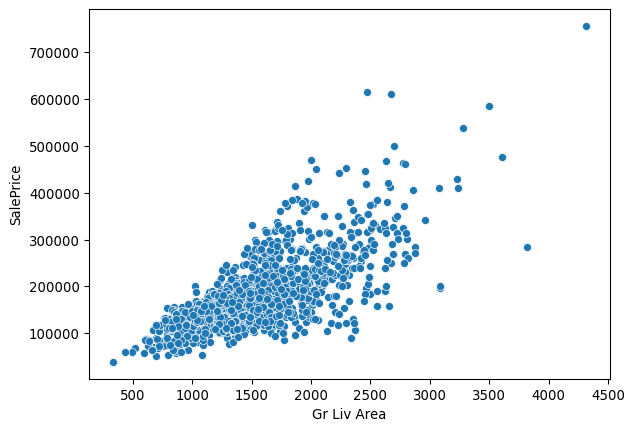

In [43]:
plt.close()
sns.scatterplot(x="Gr Liv Area", y="SalePrice", data=ames_train);
plt.show()

## Basement

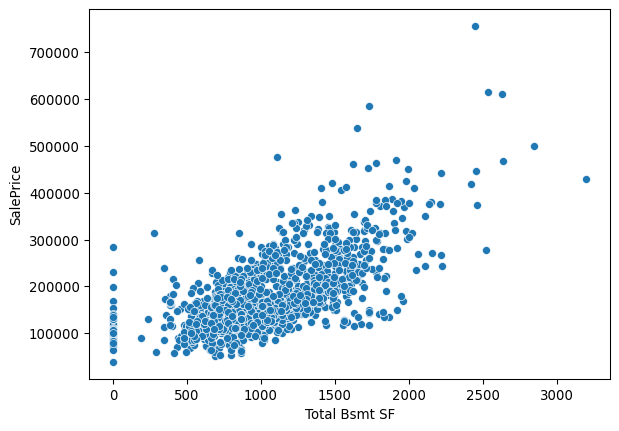

In [44]:
plt.close()
sns.scatterplot(x="Total Bsmt SF", y="SalePrice", data=ames_train);
plt.show()

## Garage

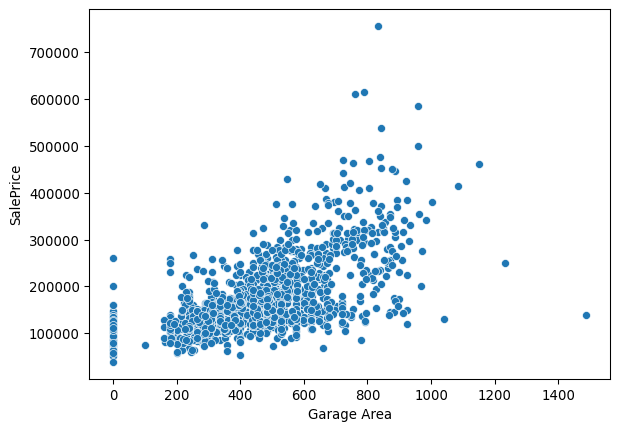

In [45]:
plt.close()
sns.scatterplot(x="Garage Area", y="SalePrice", data=ames_train);
plt.show()

## Porch

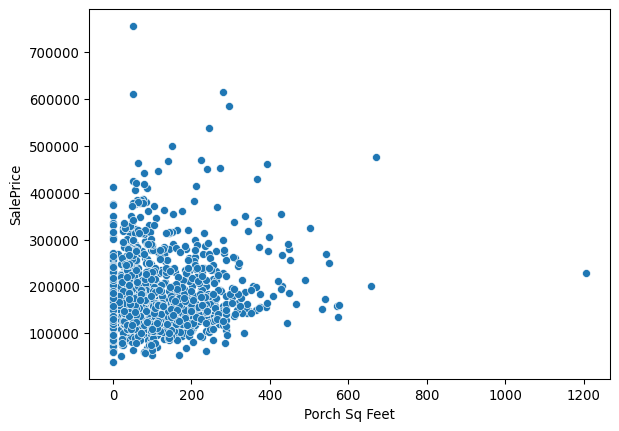

In [46]:
plt.close()
sns.scatterplot(x="Porch Sq Feet", y="SalePrice", data=ames_train);
plt.show()

## \# of bathrooms

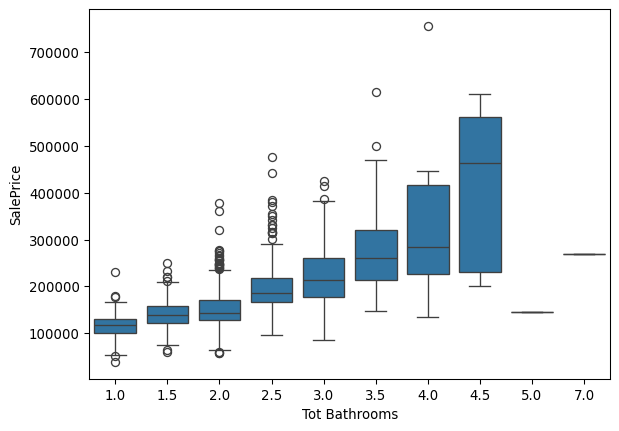

In [47]:
plt.close()
sns.boxplot(x="Tot Bathrooms", y="SalePrice", data=ames_train);
plt.show()

## Graphical analysis (Quality)

## Overall quality

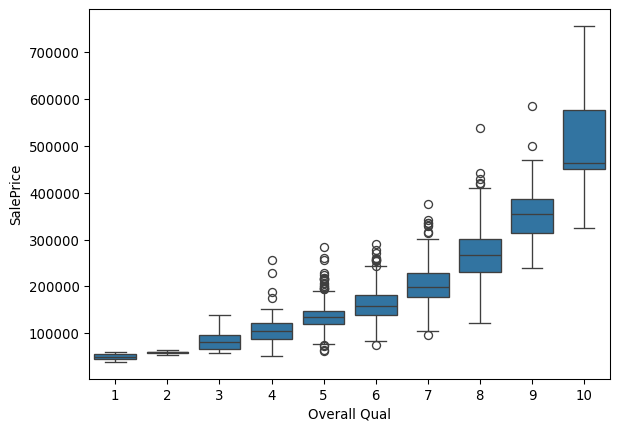

In [48]:
plt.close()
sns.boxplot(x="Overall Qual", y="SalePrice", data=ames_train);
plt.show()

## Basement quality

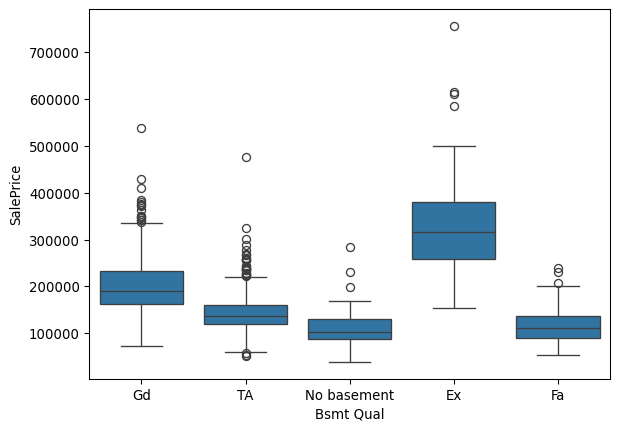

In [49]:
plt.close()
sns.boxplot(x="Bsmt Qual", y="SalePrice", data=ames_train);
plt.show()

## Exterior quality

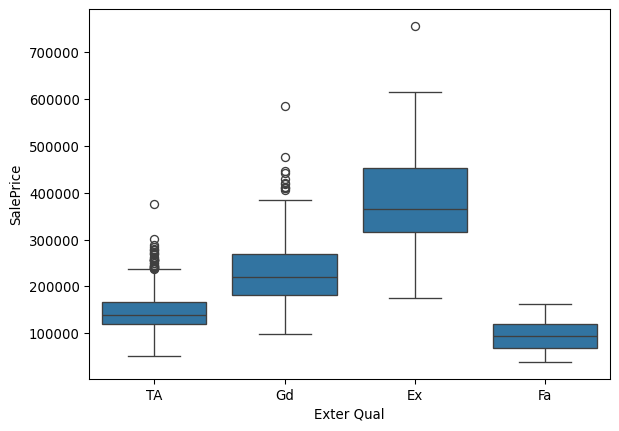

In [50]:
plt.close()
sns.boxplot(x="Exter Qual", y="SalePrice", data=ames_train);
plt.show()

## Kitchen quality

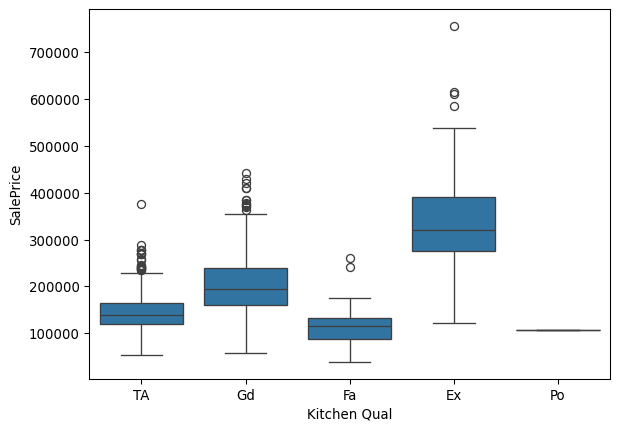

In [51]:
plt.close()
sns.boxplot(x="Kitchen Qual", y="SalePrice", data=ames_train);
plt.show()

## Graphical analysis (Other)

## House age

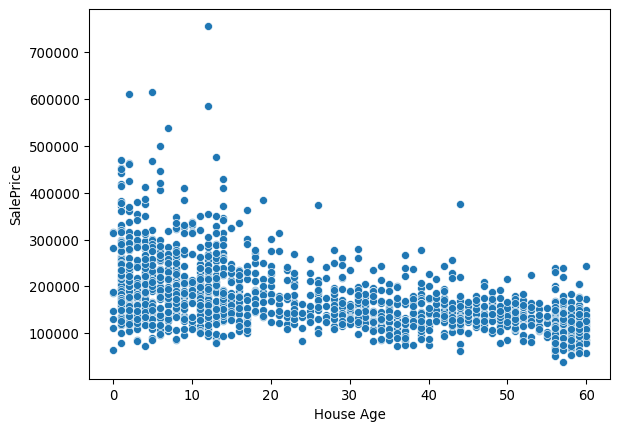

In [52]:
plt.close()
sns.scatterplot(x="House Age", y="SalePrice", data=ames_train);
plt.show()

## Area

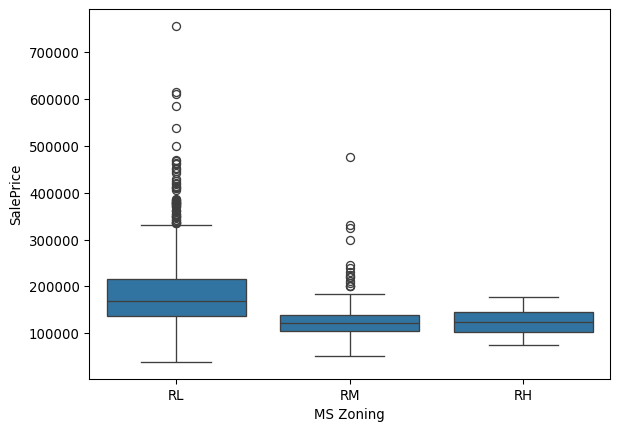

In [53]:
plt.close()
sns.boxplot(x="MS Zoning", y="SalePrice", data=ames_train);
plt.show()

## House category

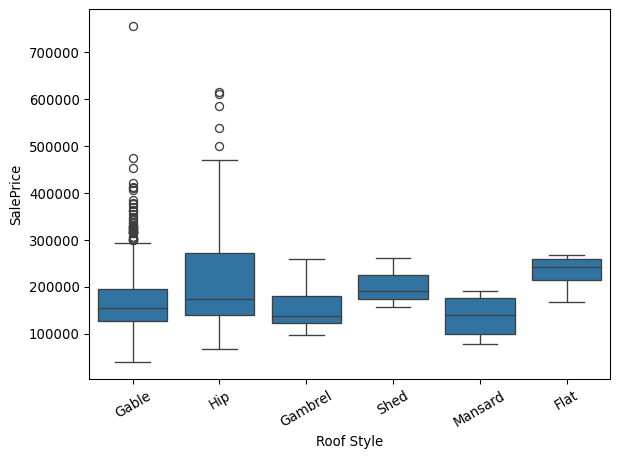

In [54]:
plt.close()
plt.xticks(rotation=30)
sns.boxplot(x="Roof Style", y="SalePrice", data=ames_train);
plt.show()

## Neighborhood

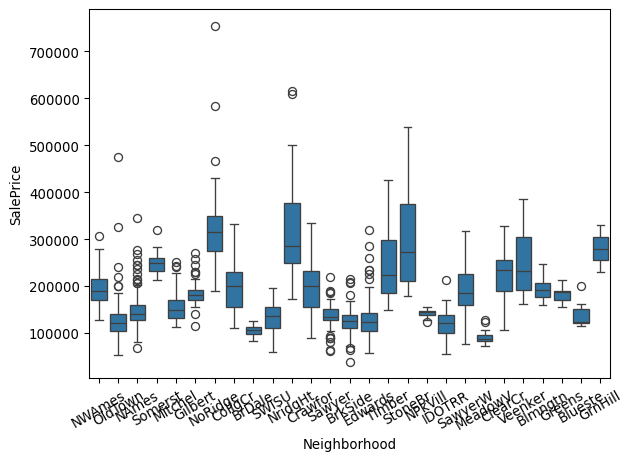

In [55]:
plt.close()
plt.xticks(rotation=30)
sns.boxplot(x="Neighborhood", y="SalePrice", data=ames_train);
plt.show()

## House class

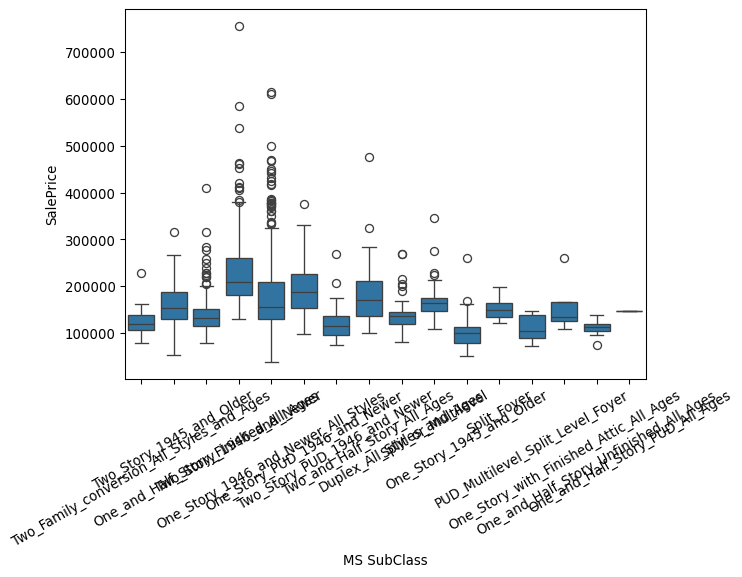

In [56]:
plt.close()
plt.xticks(rotation=30)
sns.boxplot(x="MS SubClass", y="SalePrice", data=ames_train);
plt.show()

## The choice of the loss

-   We rank the performance of different models based on some notion of
    discrepancy between the actual values and the predictions.

-   We will use the mean absolute error (MAE) on the original scale,
    namely:

$$
\text{MAE} = \frac{1}{n}\sum_{i=1}^n |\texttt{SalePrice}_i - \widehat{\texttt{SalePrice}}_i|.
$$

-   Another possible choice is:

$$
\text{RMSLE} = \sqrt{\frac{1}{n}\sum_{i=1}^n \left(\log{\{\texttt{SalePrice}_i\}} - \log{\{\widehat{\texttt{SalePrice}_i}}\}\right)^2}.
$$

## The worst-case scenario

-   Since we want to minimize the MAE on the original scale, the median
    of the training set represents our baseline.

In [57]:
median = np.median(y_train)
y_median = np.repeat(median, ames_test.shape[0]) # Prediction
median

159000.0

-   The following are the associated values of the loss based on the
    test set.

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print ("Mean absolute error (MAE): ", round(mean_absolute_error(y_median, y_test), 4))
print ("Root mean squared logarithmic error (RMSLE): ", round(np.sqrt(mean_squared_error(np.log(y_median), np.log(y_test))), 4))

Mean absolute error (MAE):  47735.5283
Root mean squared logarithmic error (RMSLE):  0.3609

-   Thus, any model having MAE higher than 45k and RMSLE higher than
    0.36 should be regarded as a <span style="color:DarkOrange">coding
    error</span>.

## A simple linear regression I

-   The first model we consider is a simple linear regression, which
    just a few predictors that are relevant to this problem.

In [59]:
X_train_simple = ames_train[['Gr Liv Area', 'Overall Qual', 'House Age', 'Tot Bathrooms']]

-   We fit the following linear model so that

$$
\texttt{SalePrice} = \beta_0 + \beta_1 \texttt{Gr Liv Area} + \cdots + \beta_4 \texttt{Tot Bathrooms}.
$$

-   The estimated coefficients are the following:

In [60]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
m_linear = LinearRegression()
m_linear.fit(X_train_simple, y_train)
m_linear.coef_ # The intercept is not included in this vector

array([   53.41690979, 25025.90405477,  -280.03872291, 15773.10205046])

## A simple linear regression II

-   To assess the performance of this very simple model, we rely on the
    values of MAE and RMSLE based on cross-validated predictions.

In [61]:
def scores_report(y, y_pred):
  print ("Mean absolute error (MAE): ", round(mean_absolute_error(y, y_pred), 4))
  print ("Root mean squared logarithmic error (RMSLE): ", round(np.sqrt(mean_squared_error(np.log(y), np.log(y_pred))), 4))

-   We also “correct” the estimates of this first linear model so that
    any prediction is higher than 30k.

In [62]:
# Predict labels under cross-validation
from sklearn.model_selection import cross_val_predict, cross_val_score

# Compute the predicted labels
y_linear = cross_val_predict(m_linear, X_train_simple, y_train, method = 'predict', cv = 5)

# A reasonable correction
y_linear = np.maximum(y_linear, 30000)

scores_report(y_train, y_linear)

Mean absolute error (MAE):  24854.4093
Root mean squared logarithmic error (RMSLE):  0.1944

## A simple linear regression III

-   The proposed model is improving over the median, but we can do much
    better.

-   The first (very effective) idea is to rely on a multiplicative
    model, so that

$$
\texttt{SalePrice} = \beta_0 \times \beta_1 \texttt{Gr Liv Area} \times \cdots \times \beta_4 \texttt{Tot Bathrooms}.
$$

-   This is equivalent to fitting a linear model on the log scale and
    then transforming back the predictions so that

In [63]:
log_y_linear = cross_val_predict(m_linear, X_train_simple, np.log(y_train), method = 'predict', cv = 5)
y_linear_log = np.exp(log_y_linear)

scores_report(y_train, y_linear_log)

Mean absolute error (MAE):  20999.2783
Root mean squared logarithmic error (RMSLE):  0.1597

## A simple linear regression IV

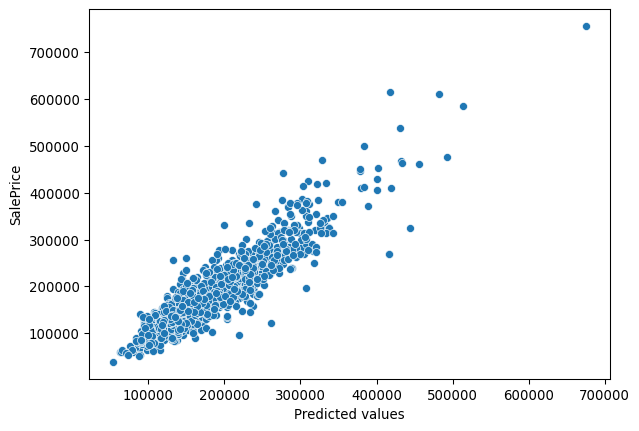

In [64]:
plt.close()
sns.scatterplot(x=y_linear_log, y=y_train);
plt.xlabel("Predicted values");
plt.show()

## Lasso I

-   A simple linear regression model is already capable of predicting
    the sale price with an average error of 20k, which is remarkable
    given its simplicity.

-   We can improve over the previous linear model by adding more
    covariates.

-   However, there are too many of them! Some form of
    <span style="color:DarkOrange">regularization</span> is needed.

-   A possibility is to use the lasso:

In [65]:
from sklearn.linear_model import LassoCV
m_lassoCV = LassoCV(cv = 5, alphas = np.linspace(0.00001, 0.001, 100), max_iter = 10000)
m_lassoCV = m_lassoCV.fit(X_train, np.log(y_train))

-   The penalization parameter (`alpha`) is selected using
    cross-validation.

-   The collection of possible values for `alphas` is the result of a
    few trials.

-   The `max_iter` has been increased, as the algorithm was not reaching
    convergence.

## Lasso II

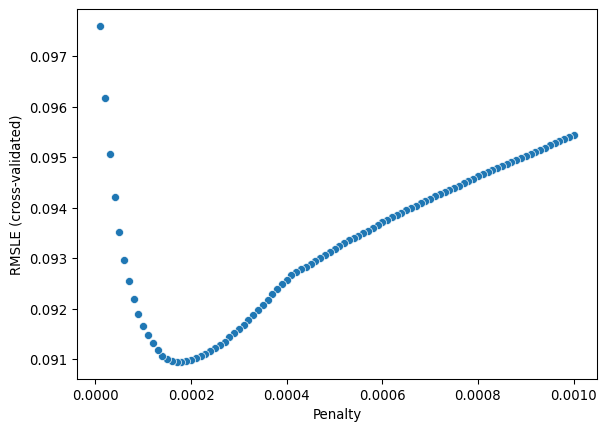

In [66]:
plt.close()
sns.scatterplot(x=m_lassoCV.alphas_, y=np.sqrt(m_lassoCV.mse_path_).mean(axis = 1))
plt.xlabel("Penalty");
plt.ylabel("RMSLE (cross-validated)");
plt.show()

## Lasso III

In [67]:
from sklearn.linear_model import Lasso
m_lasso = Lasso(alpha = m_lassoCV.alpha_, max_iter = 10000)
y_lasso_log = np.exp(cross_val_predict(m_lasso, X_train, np.log(y_train), method = 'predict', cv = 5))
scores_report(y_train, y_lasso_log)

Mean absolute error (MAE):  11615.7079
Root mean squared logarithmic error (RMSLE):  0.0912

-   The results are promising: the cross-validated MAE and RMSLE are
    much lower compared to the simple linear regression model.

-   We fit a linear model using lasso based on the entire training
    dataset.

In [68]:
m_lasso = m_lasso.fit(X_train, np.log(y_train))

-   Recall that the number of features in the training dataset is:

In [69]:
X_train.shape

(1544, 286)

-   The lasso selected only a fraction of these, which is:

In [70]:
sum(m_lasso.coef_!=0)

151

## Lasso IV

-   We can investigate which are the most relevant covariates according
    to the lasso, i.e., those having the highest regressions
    coefficients.

In [71]:
coef = pd.Series(m_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(5), coef.sort_values().tail(5)])
imp_coef

Neighborhood_MeadowV                   -0.103389
MS SubClass_One_Story_1945_and_Older   -0.082659
Neighborhood_Edwards                   -0.055314
Central Air_N                          -0.049078
Neighborhood_OldTown                   -0.047060
Alley_Pave                              0.084363
Neighborhood_Crawfor                    0.093972
Gr Liv Area                             0.122546
Exterior 1st_PreCast                    0.131542
Neighborhood_GrnHill                    0.382170
dtype: float64

## Random forest I

-   We now wish to understand whether we can further improve the
    previous model by including interactions among the covariates.

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Set the grid of parameters to explore
param_grid = {
    'max_depth' : [None],
    'max_features': [None, 50, 100]
}

# Create a base model
m_rf = RandomForestRegressor()

# Instantiate the grid search model
grid_rf = GridSearchCV(estimator = m_rf, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = 1)

# Estimation and check of the best hyperparameters (it may take some time)
grid_rf.fit(X_train, np.log(y_train));

# Estimation
grid_rf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits

{'max_depth': None, 'max_features': 100}

## Random forest II

-   The function `GridSearchCV` fits a given regression model under
    different parameter specifications and compute the cross-validated
    errors in each case.

-   Feel free to explore other possibilities: have a look at the
    [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [73]:
m_rf = RandomForestRegressor(max_features = 50, max_depth = None)
y_rf = np.exp(cross_val_predict(m_rf, X_train, np.log(y_train), method = 'predict', cv = 5))
scores_report(y_train, y_rf)

Mean absolute error (MAE):  14214.295
Root mean squared logarithmic error (RMSLE):  0.1133

-   A random forest approach is slightly worse in terms of predictions
    compared to the lasso.

-   We finally fit the model on the entire training dataset.

In [74]:
m_rf = m_rf.fit(X_train, np.log(y_train))

## Random forest III

-   The importance of each variable can be explored using the feature
    importance.

In [75]:
rf_coef = pd.Series(m_rf.feature_importances_, index = X_train.columns)
rf_coef.sort_values(ascending = False).head(15)

Overall Qual        0.153954
Gr Liv Area         0.117896
Tot Bathrooms       0.077083
Exter Qual_TA       0.062794
Garage Area         0.058808
Total Bsmt SF       0.055417
Garage Cars         0.047351
1st Flr SF          0.044049
Fireplaces          0.033596
Foundation_PConc    0.023643
Lot Area            0.020637
Kitchen Qual_TA     0.017979
BsmtFin SF 1        0.016046
House Age           0.015109
2nd Flr SF          0.015022
dtype: float64

## Gradient boosting I

-   The last approach we consider is gradient boosting (with trees).

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

# Set the grid of parameters to explore
param_grid = {
    'max_depth' : [2],
    'subsample' : [1],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'n_estimators': [2000]
}

# Create a base model
m_gb = GradientBoostingRegressor()

# Instantiate the grid search model
grid_gb = GridSearchCV(estimator = m_gb, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = 1)

# Estimation and identification of the best hyperparameters (it may take some time)
grid_gb.fit(X_train, np.log(y_train));

# Best parameters according to CV
grid_gb.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits

{'learning_rate': 0.0575, 'max_depth': 2, 'n_estimators': 2000, 'subsample': 1}

## Gradient boosting II

-   Carefully tuning the parameters of a gradient boosting algorithm is
    more complicated, in practice, compared to the lasso or random
    forest.

-   Conceptually, the operations we perform are identical, but the
    number of tuning parameters is very high.

-   Play around with `GridSearchCV` and find a better solution.

In [77]:
# Fit a linear regression model
m_gb = GradientBoostingRegressor(learning_rate =  0.0575, max_depth = 2, n_estimators =  2000, subsample = 1)

# Compute the predicted labels
y_gb = np.exp(cross_val_predict(m_gb, X_train, np.log(y_train), method = 'predict', cv = 5))

scores_report(y_train, y_gb)

Mean absolute error (MAE):  12191.4045
Root mean squared logarithmic error (RMSLE):  0.0942

In [78]:
m_gb.fit(X_train, np.log(y_train));

## Model selection

-   As a final check, we compare the model in terms of MAE and RMSLE,
    using the test set.

-   <span style="color:DarkOrange">Lasso</span>

In [79]:
y_lasso_test = np.exp(m_lasso.predict(X_test))
scores_report(y_test, y_lasso_test)

Mean absolute error (MAE):  11220.6556
Root mean squared logarithmic error (RMSLE):  0.0911

-   <span style="color:DarkOrange">Random forest</span>

In [80]:
y_rf_test = np.exp(m_rf.predict(X_test))
scores_report(y_test, y_rf_test)

Mean absolute error (MAE):  12660.8451
Root mean squared logarithmic error (RMSLE):  0.108

-   <span style="color:DarkOrange">Gradient boosting</span>

In [81]:
y_gb_test = np.exp(m_gb.predict(X_test))
scores_report(y_test, y_gb_test)

Mean absolute error (MAE):  10876.7295
Root mean squared logarithmic error (RMSLE):  0.0851

## Final considerations

-   Can we do better than this?
    -   Probably yes, but improving your predictions becomes harder and
        harder.
    -   In most problems, some uncertainty cannot be eliminated.
-   <span style="color:DarkOrange">Remark 1</span>
    -   The most accurate model is not necessarily the best model.
    -   The [Netflix Prize
        competition](https://en.wikipedia.org/wiki/Netflix_Prize) is a
        clear example of this discrepancy.
-   <span style="color:DarkOrange">Remark 2</span>
    -   In these experiments, we assume that the data generative
        mechanism is the same in the training and test set.
    -   Unfortunately, this assumption is sometimes unreasonable in many
        concrete prediction problems.
    -   Simpler and highly interpretable models might be preferable in
        those cases.